# PHY438 mini-project - Constructing a galaxy luminosity function

In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from astropy.cosmology import Planck18
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("C:\Ahzam\MSc Astrophysics\Galaxy formation and evolution\Survey_KunnathChali.csv") #Reading the data

#### Step 1: Removing Non-robustly detected galaxies

In [3]:
data2 = data[data['K-band mag'] < 20.8] #Selecting only robustly detected galaxies

#### Step 2: Histogram showing the number of counts of robustly detected galaxies with different K-band magnitudes.

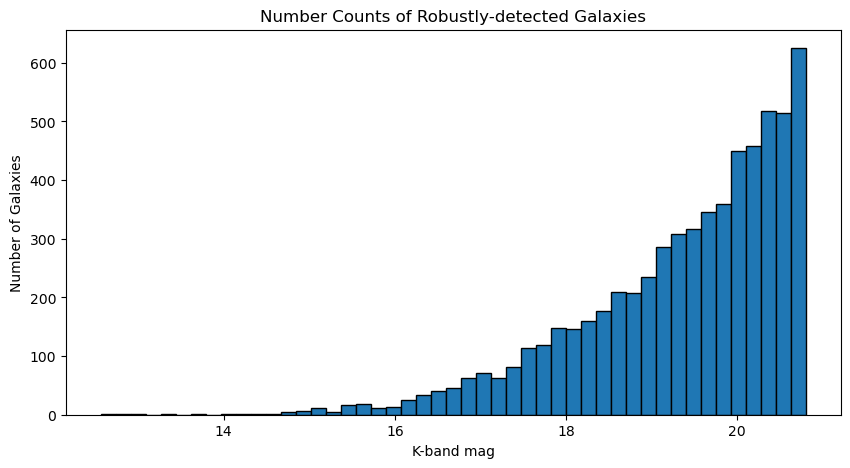

In [4]:
plt.figure(figsize=(10, 5)) #specifying the size of figure

plt.hist(data2['K-band mag'],bins='auto',edgecolor= 'black') #plotting histogram with k-band magnitude in x axis and no of galaxies at y axis.

plt.xlabel('K-band mag') #setting x-axis label

plt.ylabel('Number of Galaxies') #setting y-axis label

plt.title('Number Counts of Robustly-detected Galaxies') #title for the histogram

plt.show()

#### Step 3: Selecting galaxies below redshift 0.1

In [5]:
data3 = data2[data2['Redshift'] < 0.1] #Selection of galaxies that are at a redshift below 0.1

#### Step 4: Calculating the volume of z < 0.1 Universe covered by the survey.

The equation to find volume:
$V_s = \frac{X}{41,252.96}  [V_c(z_2) - V_c(z_1)]$

where is Vc = $\frac{4}{3} \pi d^3$

vc(z1) is the cosmological volume corresponding to the minimum redshift.

vc(z2) is the cosmological volume corresponding to the maximum redshift.
    

In [6]:
z_min = data3['Redshift'].min() #Selecting minimum value of redshift

z_max = data3['Redshift'].max() #Selecting maximum value of redshift

dp = Planck18.comoving_distance([z_min,z_max]) #calculation of only comoving distances

cosmological_volume = 4/3 * math.pi * dp**3 #calculation of cosmological volume

vc1 = cosmological_volume[0].value #cosmological volume for minimum redshift

vc2 = cosmological_volume[1].value #cosmological volume for maximum redshift

X = 10 #Survey square degree

Vs = (X/41252.96) * (vc2 -  vc1) #Volume between z_max and z_min conatined within a X square degree 

#### Step 5: calculating the luminosity distance 

In [7]:
Redshift = data3['Redshift'].to_numpy() #converting redshift values to numpy

luminosity_distance = Planck18.luminosity_distance(Redshift).value #Calculation of luminosity distance using planck 18

data3['luminosity distance'] = luminosity_distance #storing luminosity distance into original data

#### Step 6: Calculating the absolute magnitude, including errors

In [8]:
absolute_mag = data3['K-band mag'] - 5 * np.log10(data3['luminosity distance'] * 1e6) + 5 #calculation of absolute magnitude

error_absolute_mag = (5 / np.log(10)) * (data3['K-band dmag'] / data3['K-band mag'])#calculation of error of absolute magnitude

data3['absolute_mag'] = absolute_mag #storing absolute magnitude into original data

data3['error_absolute_mag'] = error_absolute_mag #storing error of absolute magnitude into original data

#### Step 7: Claculating the limiting abosulte magnitude of the survey 

In [9]:
absolut_mag_lim = 20.8 - 5 *np.log10(Planck18.luminosity_distance(0.1).value *1e6) + 5 #Calculation of limiting absolute magnitude of the survey

data4 = data3[data3['absolute_mag'] < absolut_mag_lim] #selecting galaxies with absolute magnitude less than limiting absolute magnitude

#### Step 8: Plotting the Luminosity function

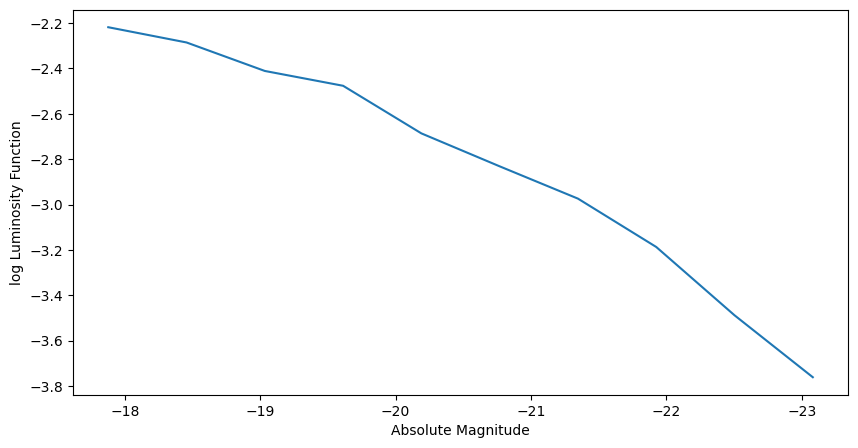

In [10]:
hist, bin_edges = np.histogram(data4['absolute_mag'], bins=10) #calculation of histogram of absolute magnitude, by dividing the entire range into 4. The resulting histogram is stored in hist and bin edges stored in bin edges.

bin_width = np.abs(bin_edges[1] - bin_edges[0]) #defining bin width

bin_centers = bin_edges[:-1] + bin_width / 2 #calculating the center of each bin

luminosity_function = hist / (Vs *  bin_width) #calculation of luminosity function which is the measure of number of galaxies per unit volume and per unit absolute magnitude interval.

plt.figure(figsize=(10, 5)) #specifying the size of figure

plt.plot(bin_centers,np.log10(luminosity_function)) #The bin center is taken in the x axis and the log10 of luminosity function is taken in y axis

plt.xlabel('Absolute Magnitude') #setting x-axis label

plt.ylabel('log Luminosity Function') #setting y-axis label

plt.gca().invert_xaxis() #inverting the axis

plt.show()

#### Step 9: Schechter function fitting to the luminosity function

Schechter function is given by the below equation:

$n(M)= 0.4 \, \ln(10) \ \phi^* \, [10^{0.4(M^* - M)}]^{(\alpha + 1)} \, \exp[-10^{0.4(M^* - M)}] \$

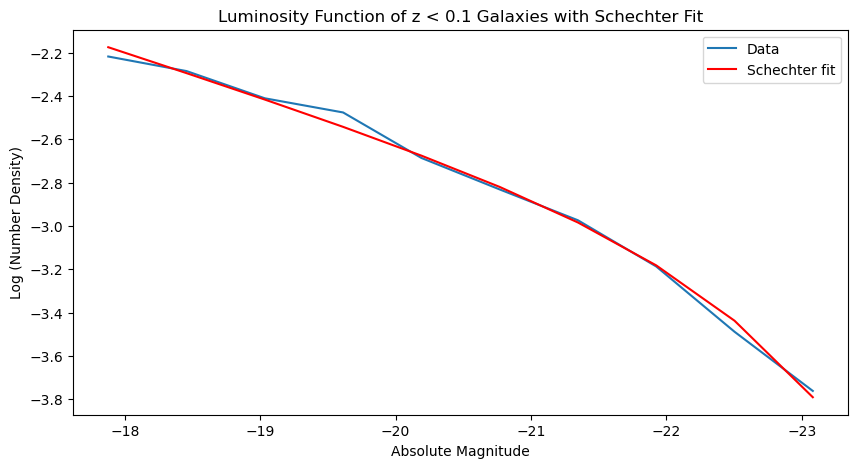

M_star: -22.78 ± 0.14
phi_star: 0.0017 ± 0.0003
alpha: -1.50 ± 0.03


In [11]:
#Defining schechter function to a luminosity function 
def log_schechter(M, M_star, log_phi_star, alpha):
    phi_star = 10**log_phi_star
    x = 10**(-0.4 * (M - M_star))
    return np.log10(0.4 * np.log10(10) * phi_star * x**(alpha + 1) * np.exp(-x)) #the data is plotted in log


M_star_init, log_phi_star_init, alpha_init = -16, np.log10(0.02), 1 #Initial guesses for Schechter function parameters, M_star, phi_star, alpha. Phi star is taken in log

p0 = [M_star_init, log_phi_star_init, alpha_init] #Variable containing the initial guesses of Schechter function

popt, pcov = curve_fit(log_schechter, bin_centers, np.log10(luminosity_function), p0=p0) #Fitting the schechter function using curve fit.

M_star_fit, log_phi_star_fit, alpha_fit = popt #Extracting the best fitting values for schechter function parameters, and storing the values in variables M_star_fit, log_phi_star_fit and alpha_fit

phi_star_fit = 10**log_phi_star_fit #Converting the best fitting log_phi_star value to its original phi_star value

M_star_err, log_phi_star_err, alpha_err = np.sqrt(np.diag(pcov)) #Storing the uncertainities in M_star_fit, log_phi_star_fit, alpha_fit, into variables named M_star_err, log_phi_star_err, alpha_err respectively.

phi_star_err = np.abs(log_phi_star_err * phi_star_fit * np.log(10)) #Measuring the uncertainity in phi_star when uncertainity in log_phi_star is given

plt.figure(figsize=(10, 5)) #specifying the size of figure

plt.plot(bin_centers, np.log10(luminosity_function), label='Data') #plotting the luminosity function with the bin center taken in the x axis and the log10 of luminosity function taken in y axis

plt.plot(bin_centers, log_schechter(bin_centers, *popt), 'r-', label='Schechter fit') #plotting the schechter fit against bin centers

plt.xlabel('Absolute Magnitude') #Setting the lable for x-axis

plt.ylabel('Log (Number Density)') #Setting the label for y-axis

plt.title('Luminosity Function of z < 0.1 Galaxies with Schechter Fit') #Setting the title for the plot

plt.gca().invert_xaxis() #inverting the axis

plt.legend() #Plotting the legend, red represents Schechter fit and blue represents the luminosity function.

plt.show()


print(f"M_star: {M_star_fit:.2f} ± {M_star_err:.2f}") #Printing the best value and uncertainity for M_star

print(f"phi_star: {phi_star_fit:.4f} ± {phi_star_err:.4f}") #Printing the best value and uncertainity for phi_star

print(f"alpha: {alpha_fit:.2f} ± {alpha_err:.2f}") #Printing the best value and uncertainity for alpha

In [12]:
Vs

79791.54323142926